# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
# Unity ml-agents path
import sys
sys.path.append("../python/")

In [3]:
from unityagents import UnityEnvironment
import numpy as np

In [4]:
env = UnityEnvironment(file_name="../Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [48]:
import maddpg_v2
from imp import reload
reload(maddpg_v2)
from maddpg_v2 import *

In [74]:
# from maddpg_agent import *

import matplotlib.pyplot as plt
%matplotlib inline
import time


def train(n_episodes=500, max_t=1000, random_seed=1, agent=None, debug=False):
    if agent == None:
        agent = [Agent(state_size=state_size, action_size=action_size, 
                          random_seed=random_seed, 
                       num_agents=num_agents, agent_index=i) for i in range(num_agents)]
        
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_plot = []
    scores_ave = []
    scores_agent = []
    c_loss_plot = [[] for i in range(num_agents)]
    a_loss_plot = [[] for i in range(num_agents)]
    total_t = 0
    
    for i_episode in range(1, n_episodes + 1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        
        time_start = time.time()
        for _ in range(max_t):
            total_t += 1
            actions = [ agent[i].act(states[i]) for i in range(num_agents) ]
            actions = np.vstack(actions)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations  # get the next state
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done  # see if episode has finished
            states = next_states
            scores += rewards
            
            for i in range(num_agents):
                c_loss, a_loss = agent[i].step(states[i], states, 
                                               actions[i], actions, 
                                            rewards[i], next_states[i], next_states, 
                                            dones[i], timestep=total_t)            
                
                if len(c_loss) > 0: 
                    c_loss_plot[i] += c_loss
                if len(a_loss) > 0: 
                    a_loss_plot[i] += a_loss
                
            if np.any(dones):
                break
            
        duration = time.time() - time_start
        scores_window.append(np.mean(scores))  # save most recent score
        scores_plot.append(np.mean(scores))
        scores_ave.append(np.mean(scores_window))
        scores_agent.append(scores)
                
        print('\rEpisode {}({}sec)\t MIN:{:.2f} MAX:{:.2f} MEAN:{:.2f} MEANo100:{:.2f} Batch Size: {} {}'.format(i_episode, 
                                    round(duration), np.min(scores), 
                                     np.max(scores), np.mean(scores), 
                                     np.mean(scores_window), 
                                     format(len(agent[0].memory)), ' '*10), end="")
        if i_episode % 100 == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}\
                \tTimestep: {}'.format(i_episode, 
                                       np.mean(scores_window), 
                                       total_t))
            # plot the scores
            fig, ax = plt.subplots()
            
            plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
            for i in range(num_agents):
                plt.plot(np.arange(len(np.vstack(scores_agent))), 
                         np.vstack(scores_agent)[:,i], label='Agent {}'.format(i+1))
            plt.plot(np.arange(len(scores_plot)), scores_plot, label='Score Ave')
            plt.xlabel('Episode #')
            ax.legend()
            plt.show()
            
            if len(np.array(c_loss_plot).reshape(-1)):
                # c loss
#                 print(c_loss_plot)
                c_loss_agents = np.array(c_loss_plot).reshape(num_agents, -1)
#                 print(c_loss_agents)
                fig, ax = plt.subplots()
                for i in range(num_agents):
                    plt.plot(np.arange(len(c_loss_agents[i])), c_loss_agents[i], label='Agent {}'.format(i+1))
                plt.xlabel('Learn #')
                plt.ylabel('Q')
                ax.legend()
                plt.show()
            
            if len(np.array(a_loss_plot).reshape(-1)):
                # a loss
                a_loss_agents = np.array(a_loss_plot).reshape(num_agents, -1)
                fig, ax = plt.subplots()
                for i in range(num_agents):
                    plt.plot(np.arange(len(a_loss_agents[i])), a_loss_agents[i], label='Agent {}'.format(i+1))
                plt.xlabel('Learn #')
                plt.ylabel('Policy')
                ax.legend()
                plt.show()
            
            for i in range(num_agents):
                torch.save(agent[i].actor_local.state_dict(), 'actor{}_{}.pth'.format(i, i_episode))
                torch.save(agent[i].critic_local.state_dict(), 'critic{}_{}.pth'.format(i, i_episode))

        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            for i in range(num_agents):
                torch.save(agent[i].actor_local.state_dict(), 'actor{}.pth'.format(i))
                torch.save(agent[i].critic_local.state_dict(), 'critic{}.pth'.format(i))
            break
            
    return scores_ave, agent


#### Sanity test

```python
# TEST
BUFFER_SIZE = 32
BATCH_SIZE = 8         # minibatch size
LEARN_EVERY = 1       # learning timestep interval
LEARN_NUM = 1           # number of learning passes
LEARN_AFTER = 0
```

In [11]:
import maddpg_v2
from imp import reload
reload(maddpg_v2)
from maddpg_v2 import *

In [12]:
train(n_episodes=4)

Episode 4(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 58           

([-0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291,
  -0.004999999888241291],
 [<maddpg_v2.Agent at 0xa6096a0>, <maddpg_v2.Agent at 0x527e898>])

In [13]:
def play(play_agent, t=10):
    # trained model
    # play times
    for i in range(t):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
#             actions = play_agent.act(states, add_noise=False)                  # all actions between -1 and 1
            actions = [ play_agent[i].act(states[i], add_noise=False) for i in range(num_agents) ]
            actions = np.vstack(actions)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (sum over agents) from episode {}: {:.2f}'.format(i, np.sum(scores)))

#### Experiment 7

Seperate DDPG agent for ma

Hyperparameters:

```python
BUFFER_SIZE = 2**17  # replay buffer size
BATCH_SIZE = 1000         # minibatch size
GAMMA = 0.95            # discount factor
TAU_ACTOR = 1e-2              # for soft update of target parameters
TAU_CRITIC = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 20        # learning timestep interval
LEARN_NUM = 10          # number of learning passes
LEARN_AFTER = 0
SEED = 1
```

In [75]:
import maddpg_v2
from imp import reload
reload(maddpg_v2)
from maddpg_v2 import *

Episode 100(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 1807           
Episode 100	Average Score: 0.00                	Timestep: 1807


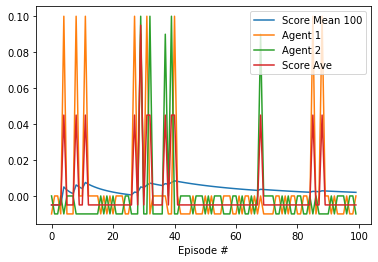

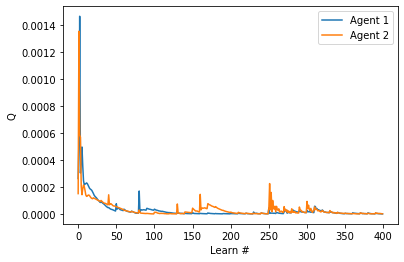

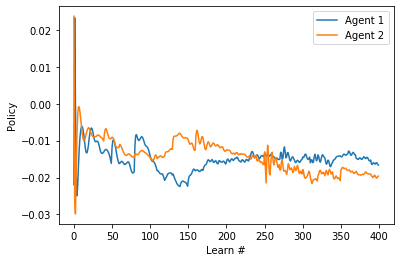

Episode 200(3sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.00 Batch Size: 3572             
Episode 200	Average Score: 0.00                	Timestep: 3572


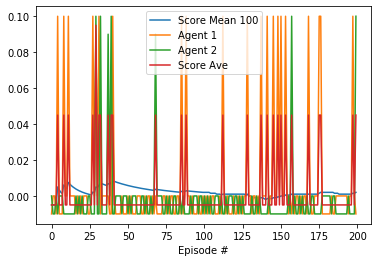

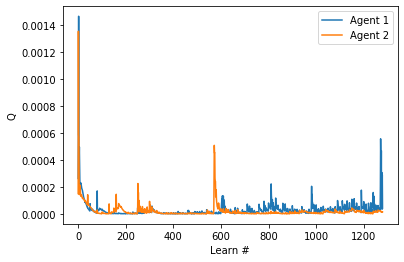

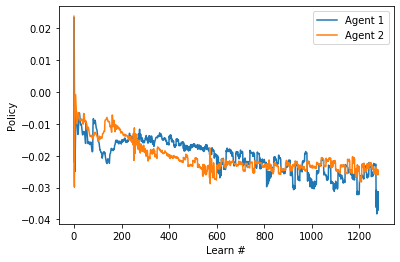

Episode 300(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 5315           
Episode 300	Average Score: 0.00                	Timestep: 5315


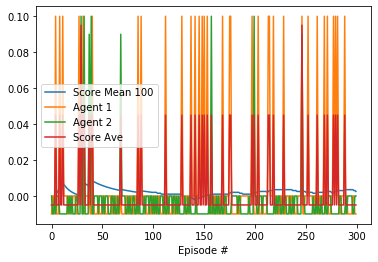

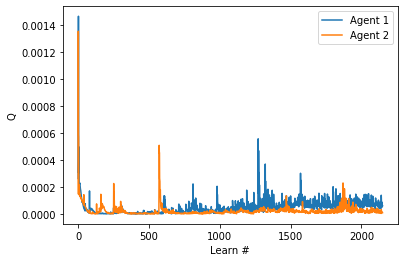

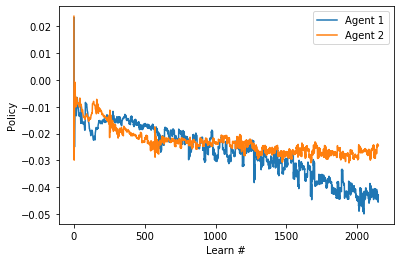

Episode 400(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 6773           
Episode 400	Average Score: -0.00                	Timestep: 6773


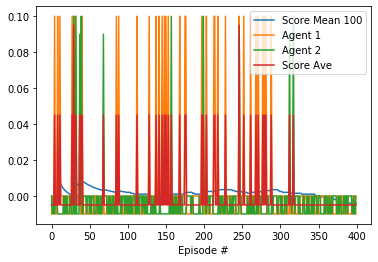

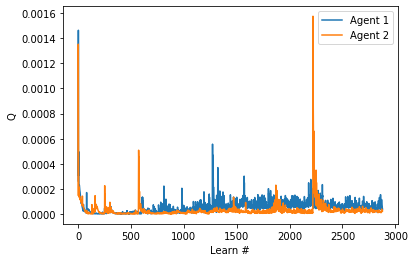

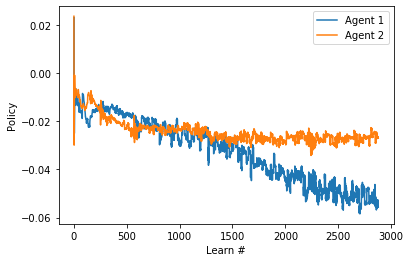

Episode 500(5sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:-0.00 Batch Size: 8228            
Episode 500	Average Score: -0.00                	Timestep: 8228


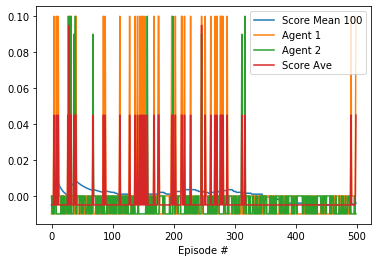

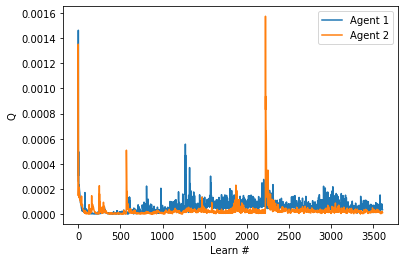

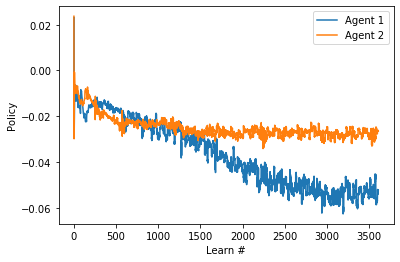

Episode 600(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 9879            
Episode 600	Average Score: 0.00                	Timestep: 9879


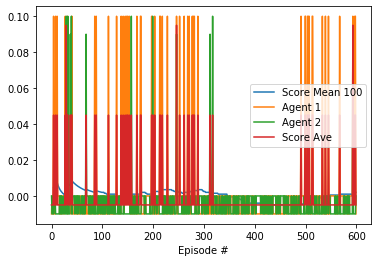

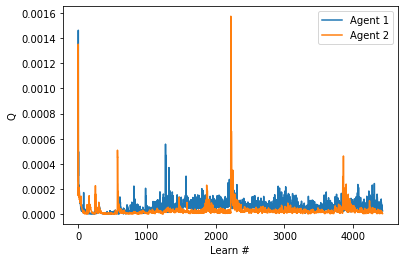

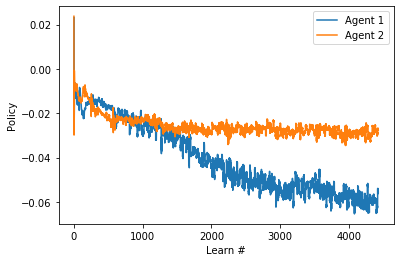

Episode 700(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 11316           
Episode 700	Average Score: -0.00                	Timestep: 11316


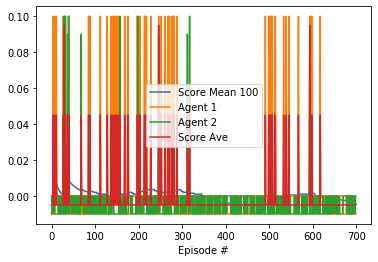

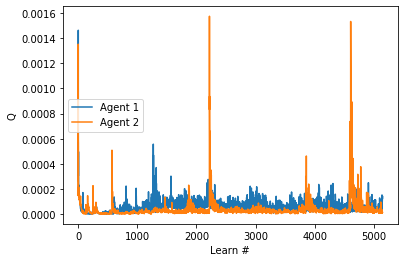

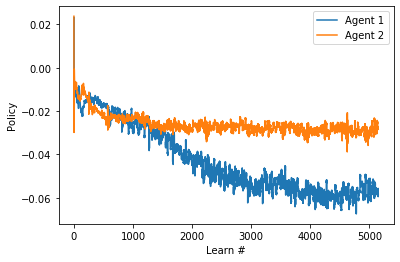

Episode 800(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 12803           
Episode 800	Average Score: -0.00                	Timestep: 12803


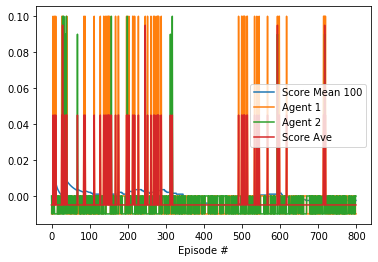

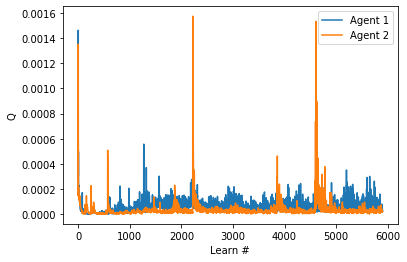

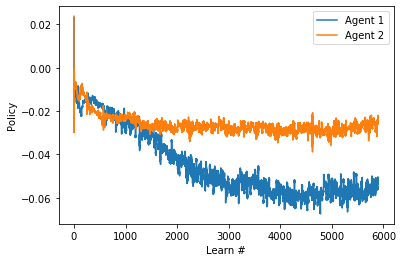

Episode 900(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 14223           
Episode 900	Average Score: -0.00                	Timestep: 14223


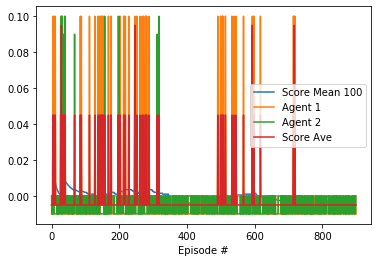

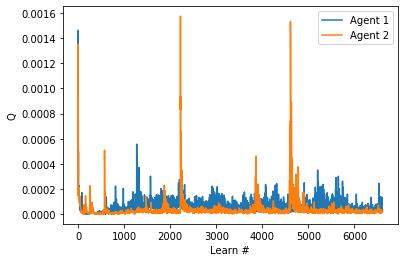

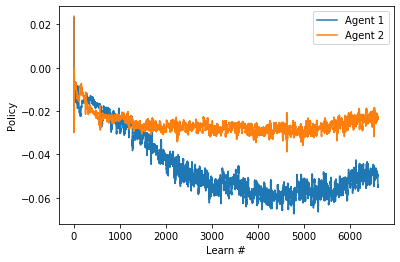

Episode 1000(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 15643           
Episode 1000	Average Score: -0.00                	Timestep: 15643


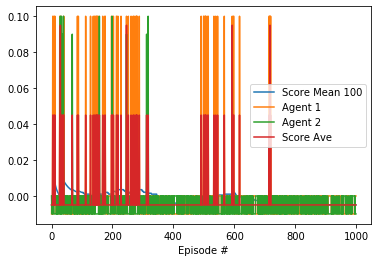

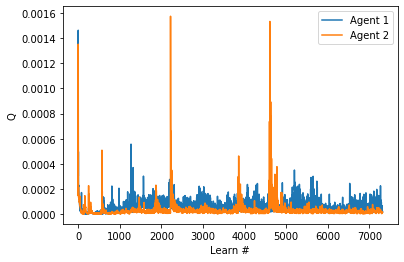

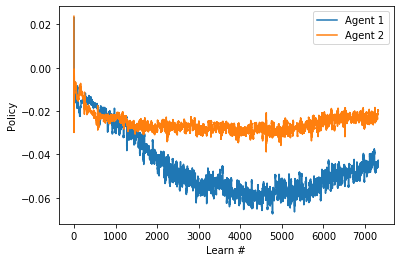

Episode 1100(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 17063           
Episode 1100	Average Score: -0.00                	Timestep: 17063


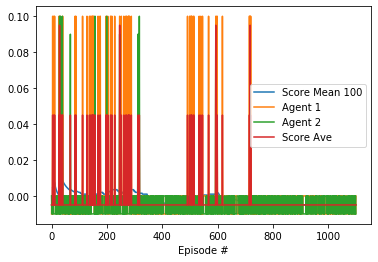

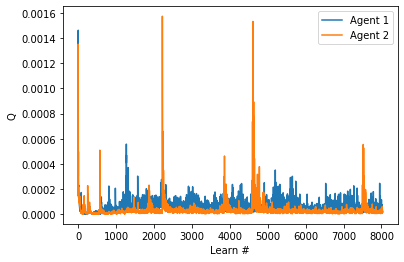

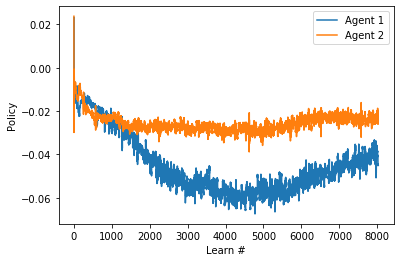

Episode 1200(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 18483           
Episode 1200	Average Score: -0.00                	Timestep: 18483


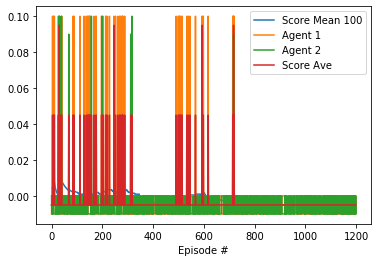

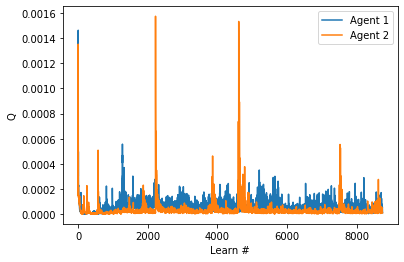

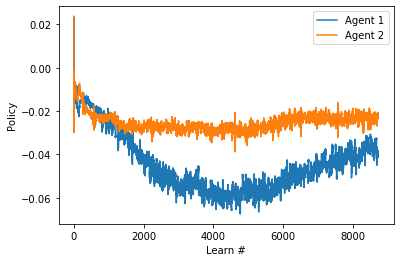

Episode 1300(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 19903           
Episode 1300	Average Score: -0.00                	Timestep: 19903


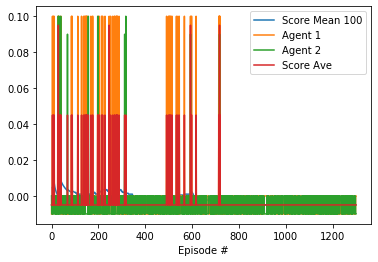

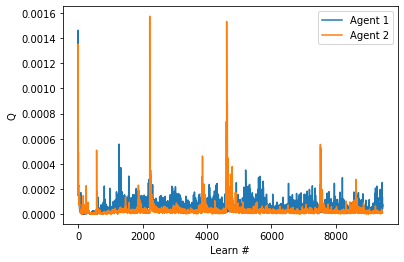

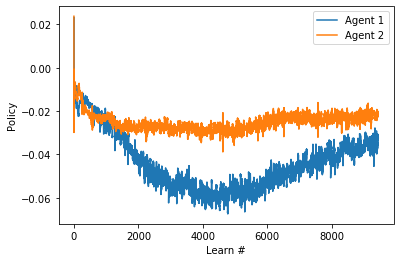

Episode 1400(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 21323           
Episode 1400	Average Score: -0.00                	Timestep: 21323


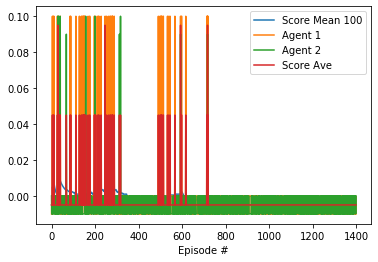

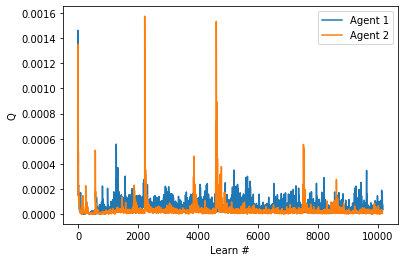

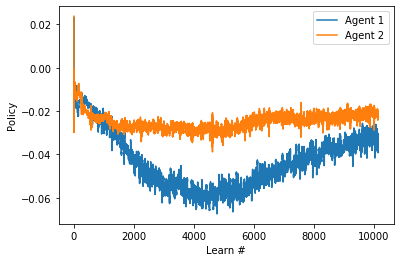

Episode 1500(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 22743           
Episode 1500	Average Score: -0.00                	Timestep: 22743


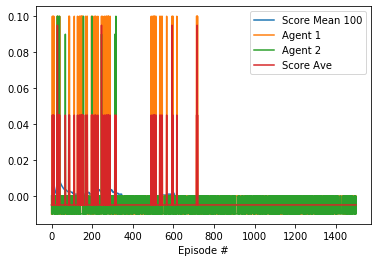

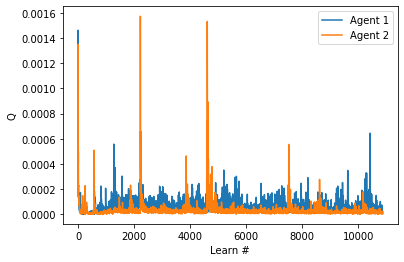

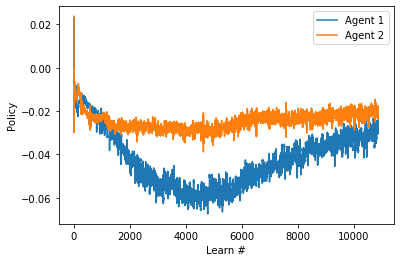

Episode 1600(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 24163           
Episode 1600	Average Score: -0.00                	Timestep: 24163


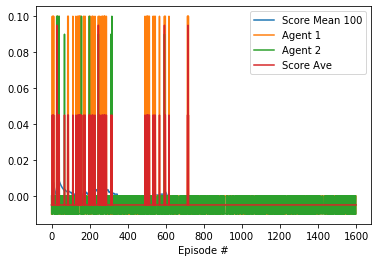

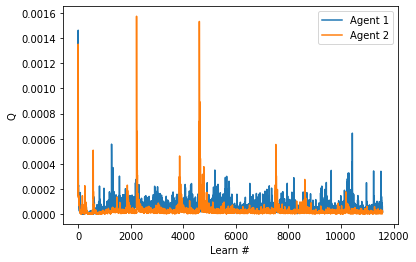

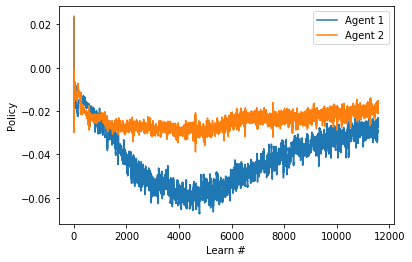

Episode 1700(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 25583           
Episode 1700	Average Score: -0.00                	Timestep: 25583


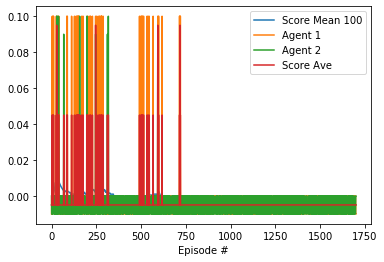

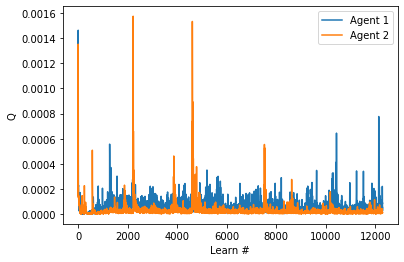

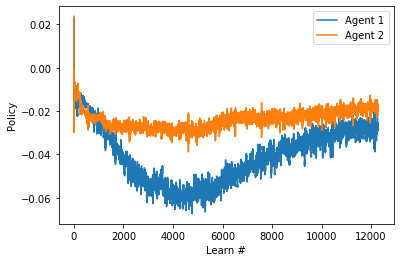

Episode 1800(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 27003           
Episode 1800	Average Score: -0.00                	Timestep: 27003


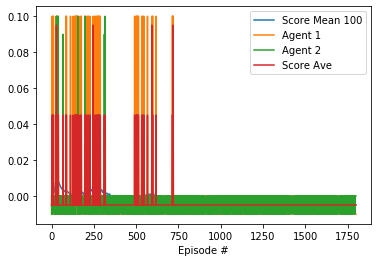

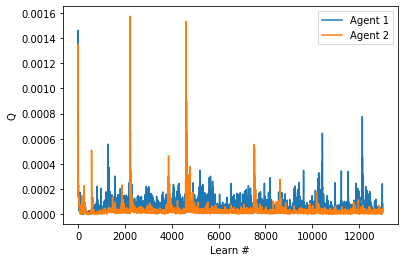

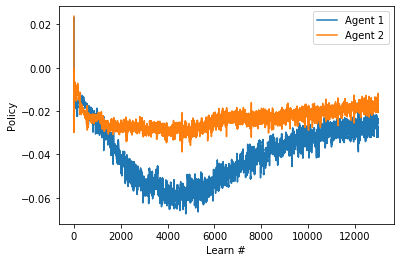

Episode 1900(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 28423           
Episode 1900	Average Score: -0.00                	Timestep: 28423


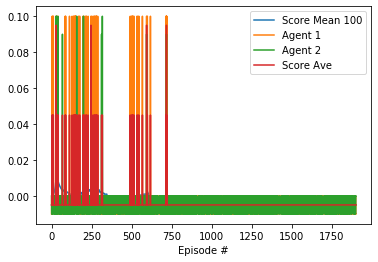

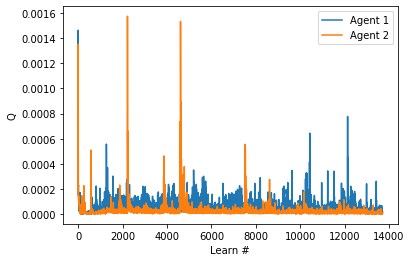

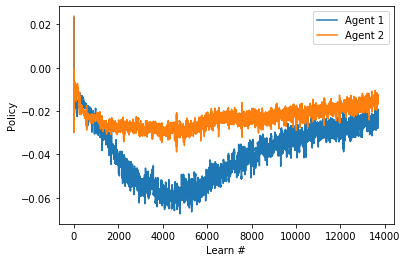

Episode 2000(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 29843           
Episode 2000	Average Score: -0.00                	Timestep: 29843


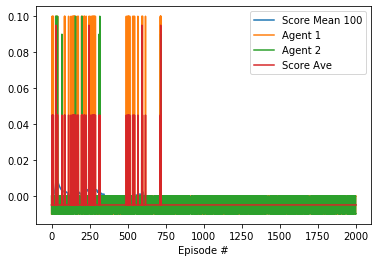

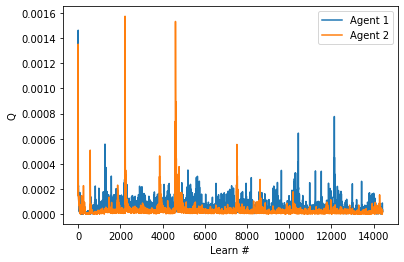

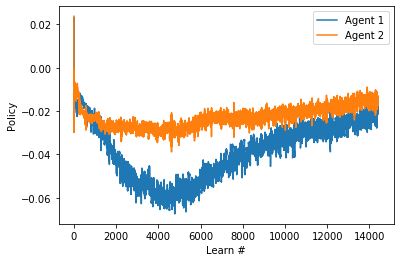

Episode 2100(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 31263           
Episode 2100	Average Score: -0.00                	Timestep: 31263


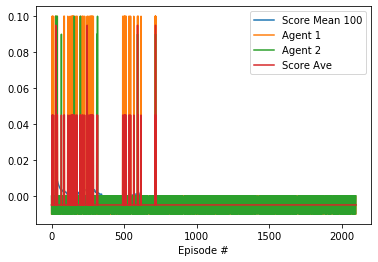

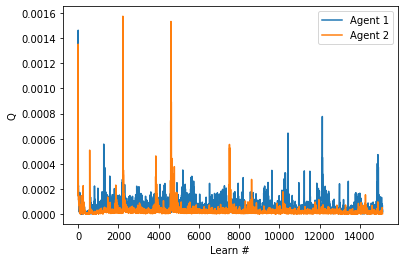

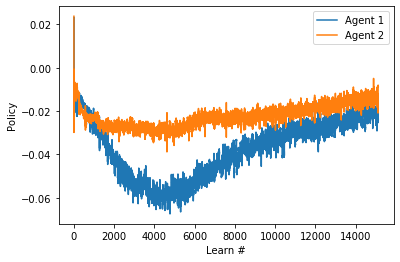

Episode 2200(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 32683           
Episode 2200	Average Score: -0.00                	Timestep: 32683


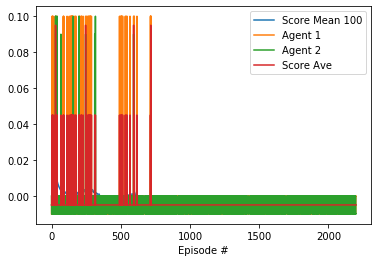

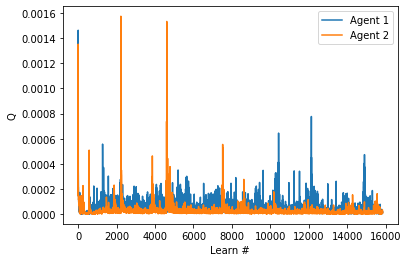

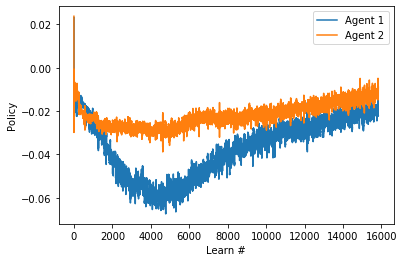

Episode 2300(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 34103           
Episode 2300	Average Score: -0.00                	Timestep: 34103


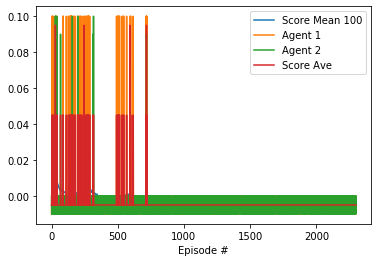

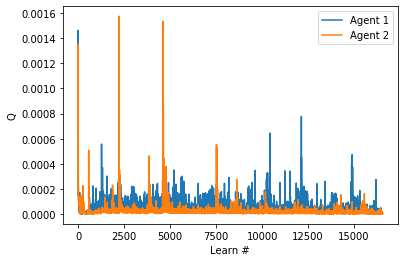

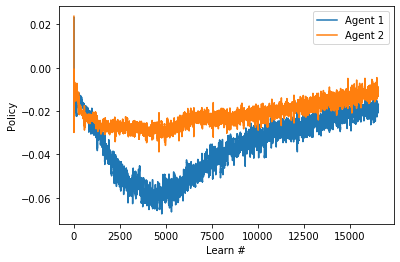

Episode 2400(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 35523           
Episode 2400	Average Score: -0.00                	Timestep: 35523


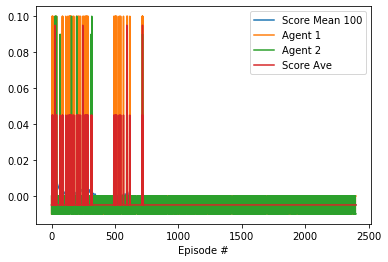

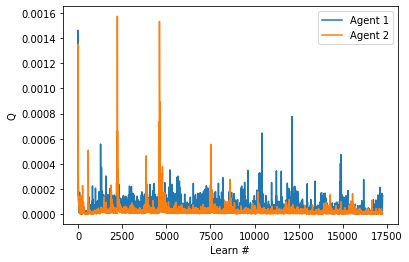

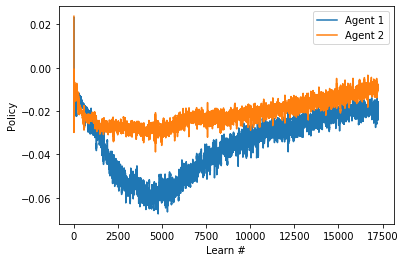

Episode 2500(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 36943           
Episode 2500	Average Score: -0.00                	Timestep: 36943


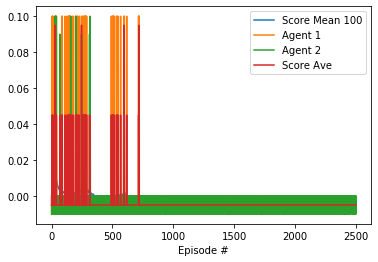

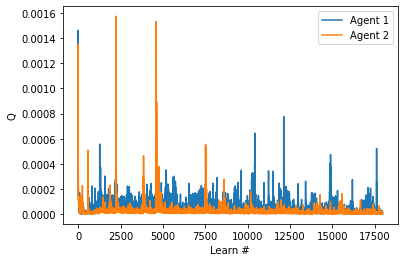

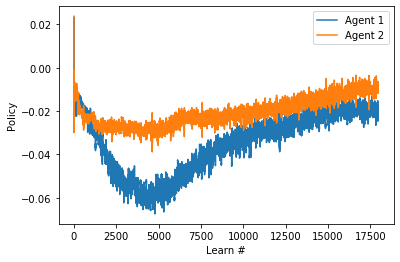

Episode 2600(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 38363           
Episode 2600	Average Score: -0.00                	Timestep: 38363


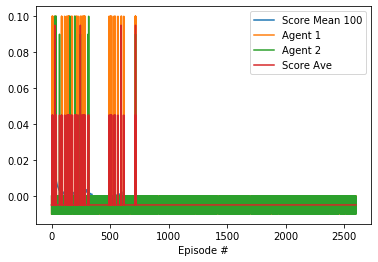

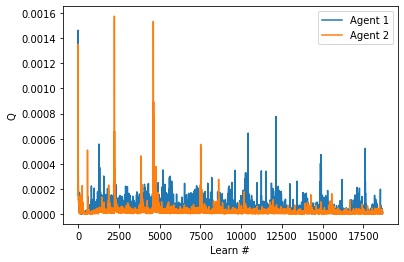

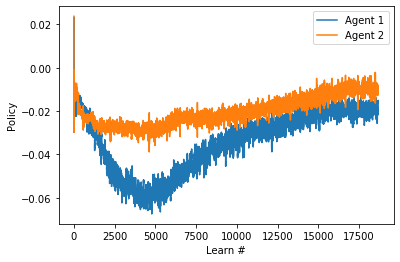

Episode 2700(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 39783           
Episode 2700	Average Score: -0.00                	Timestep: 39783


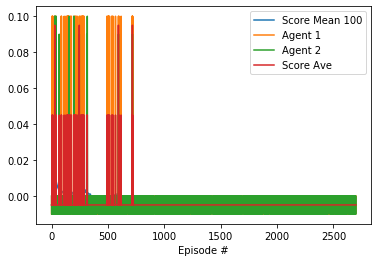

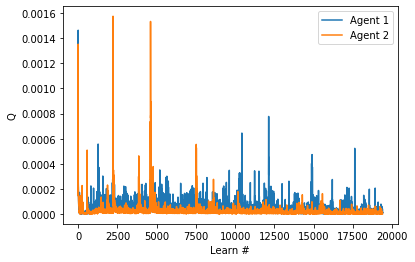

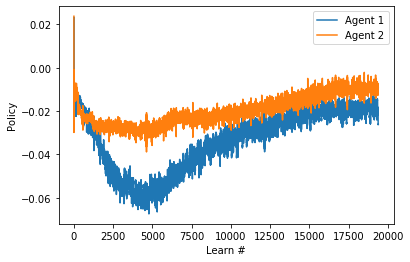

Episode 2800(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 41203           
Episode 2800	Average Score: -0.00                	Timestep: 41203


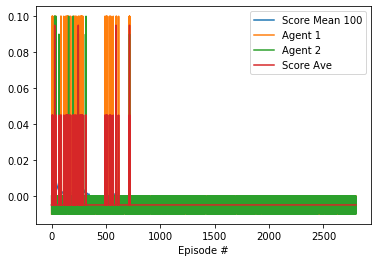

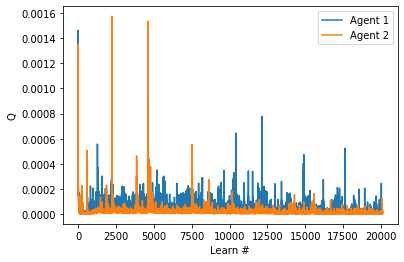

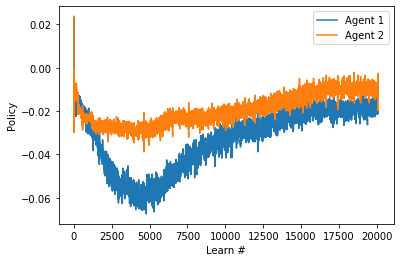

Episode 2900(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 42623           
Episode 2900	Average Score: -0.00                	Timestep: 42623


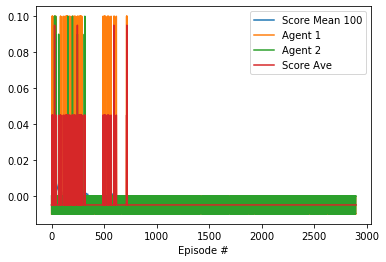

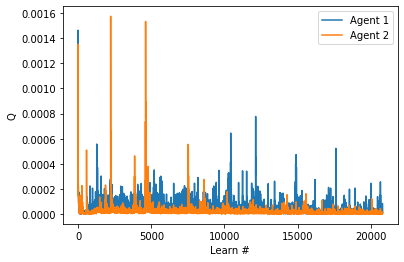

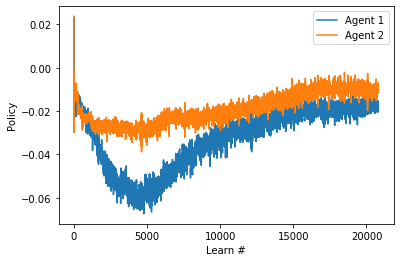

Episode 3000(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 44058           
Episode 3000	Average Score: -0.00                	Timestep: 44058


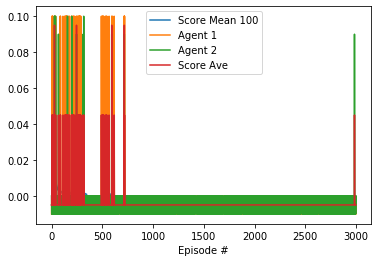

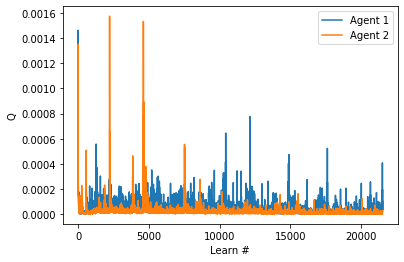

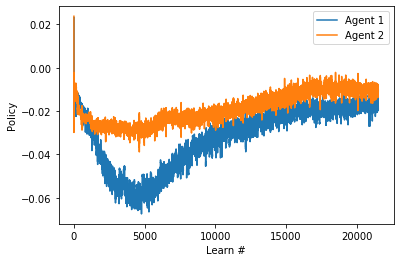

Episode 3100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 45519           
Episode 3100	Average Score: -0.00                	Timestep: 45519


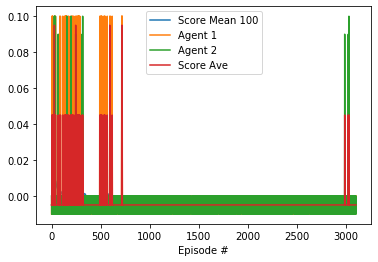

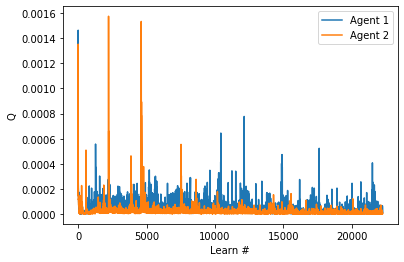

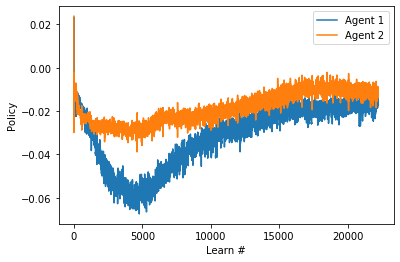

Episode 3200(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 46939           
Episode 3200	Average Score: -0.00                	Timestep: 46939


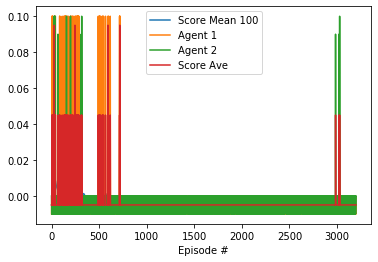

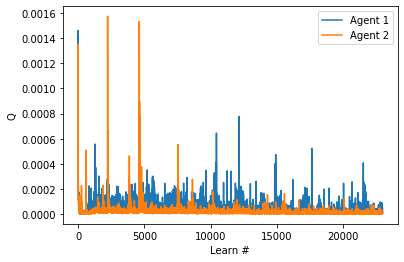

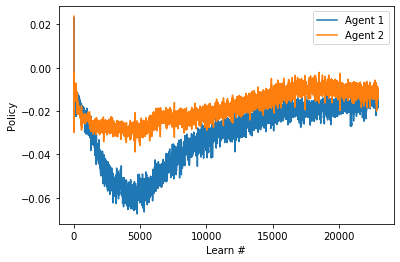

Episode 3300(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 48359           
Episode 3300	Average Score: -0.00                	Timestep: 48359


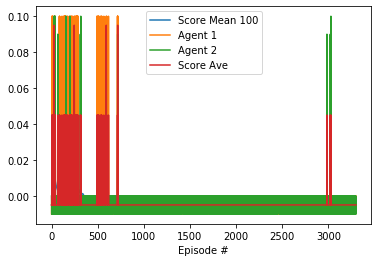

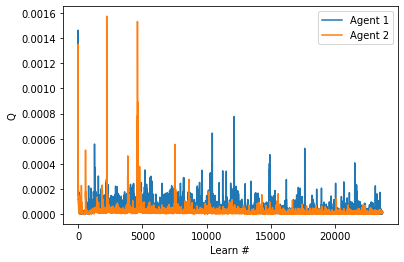

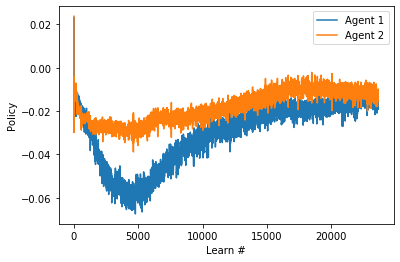

Episode 3400(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 49811           
Episode 3400	Average Score: -0.00                	Timestep: 49811


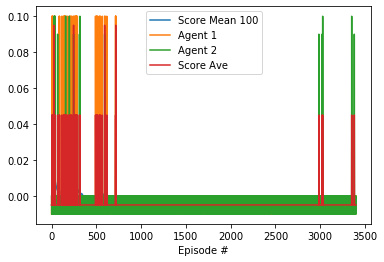

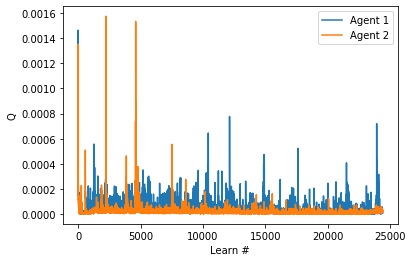

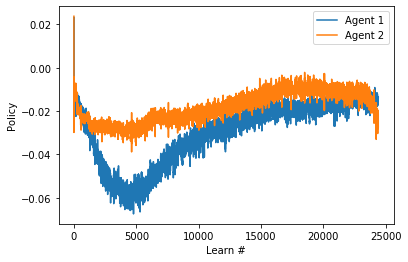

Episode 3500(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 51227           
Episode 3500	Average Score: -0.00                	Timestep: 51227


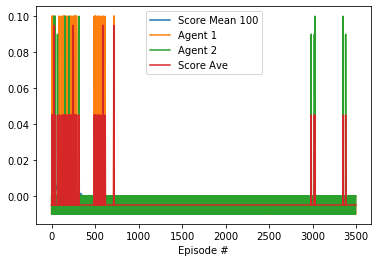

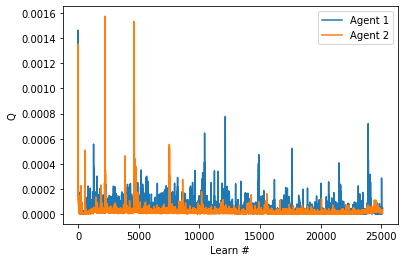

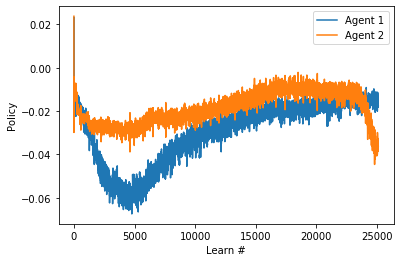

Episode 3600(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 52663           
Episode 3600	Average Score: -0.00                	Timestep: 52663


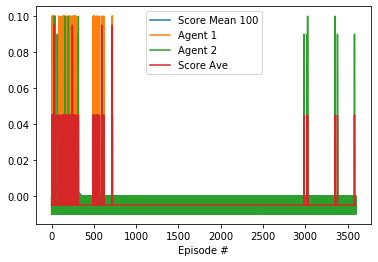

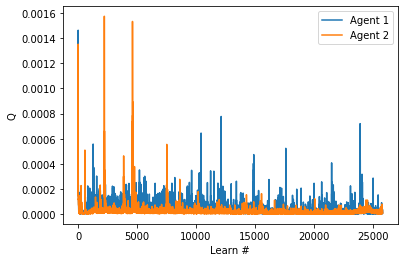

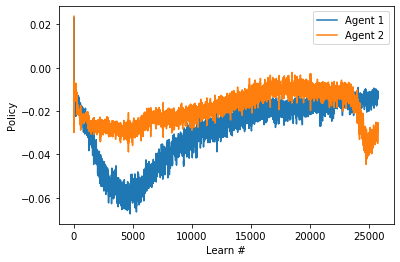

Episode 3700(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 54083           
Episode 3700	Average Score: -0.00                	Timestep: 54083


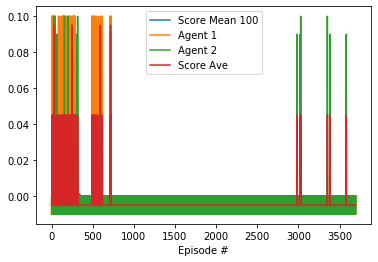

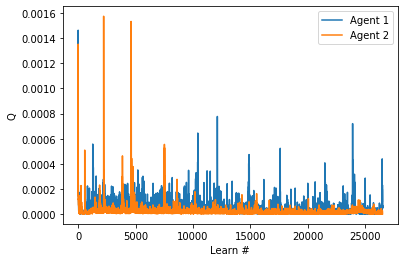

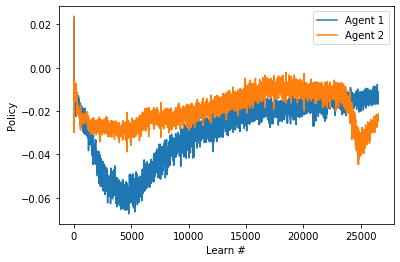

Episode 3800(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 55502           
Episode 3800	Average Score: -0.00                	Timestep: 55502


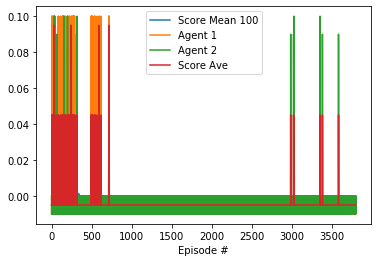

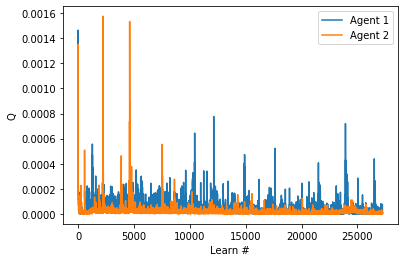

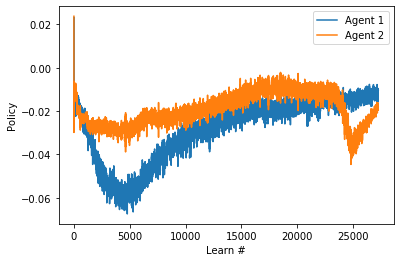

Episode 3900(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 56937           
Episode 3900	Average Score: -0.00                	Timestep: 56937


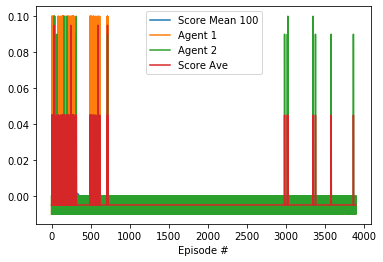

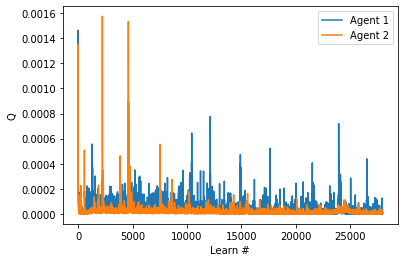

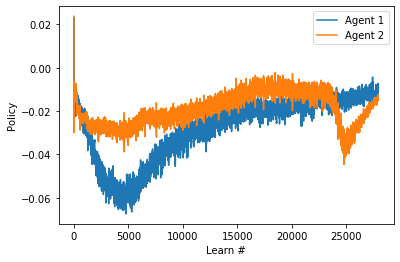

Episode 4000(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 58387           
Episode 4000	Average Score: -0.00                	Timestep: 58387


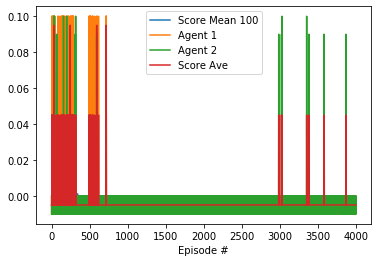

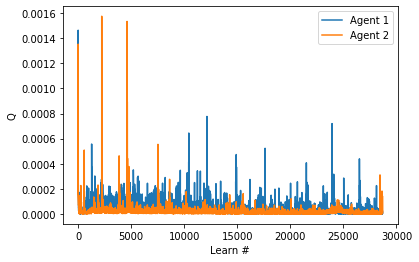

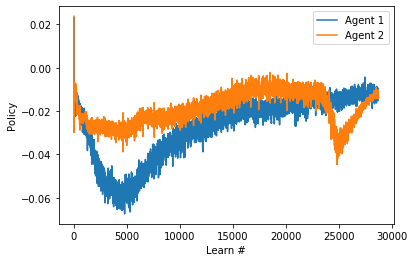

Episode 4100(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 59807           
Episode 4100	Average Score: -0.00                	Timestep: 59807


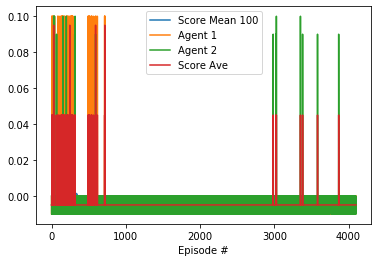

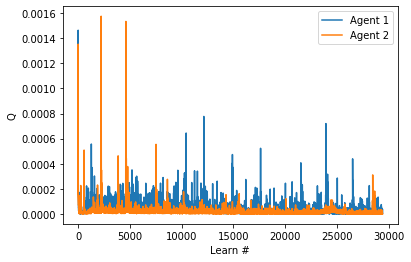

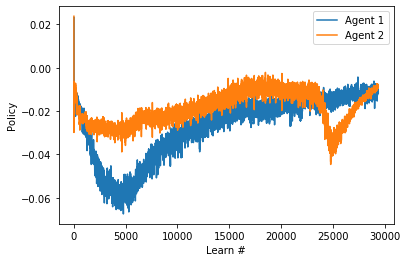

Episode 4200(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 61227           
Episode 4200	Average Score: -0.00                	Timestep: 61227


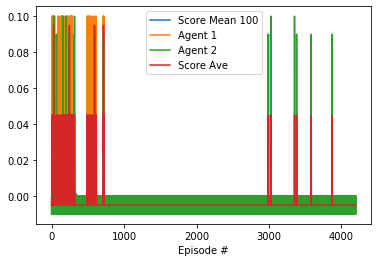

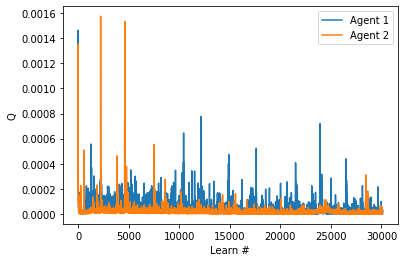

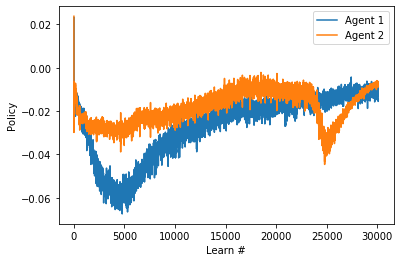

Episode 4300(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 62646           
Episode 4300	Average Score: -0.00                	Timestep: 62646


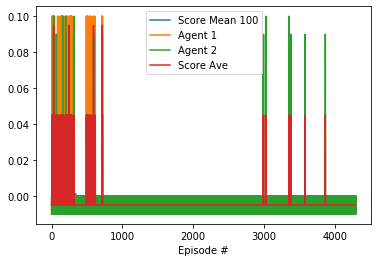

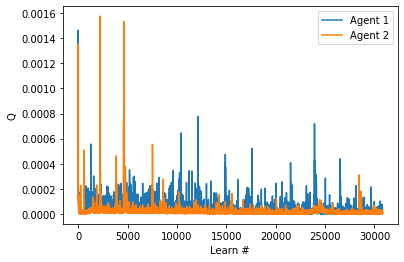

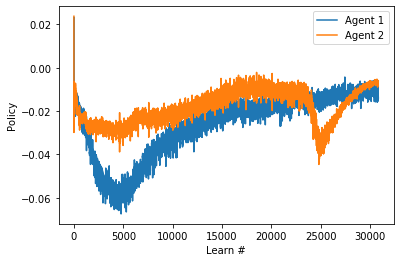

Episode 4400(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 64061           
Episode 4400	Average Score: -0.00                	Timestep: 64061


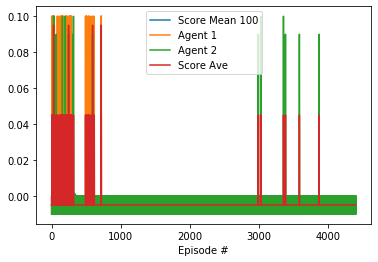

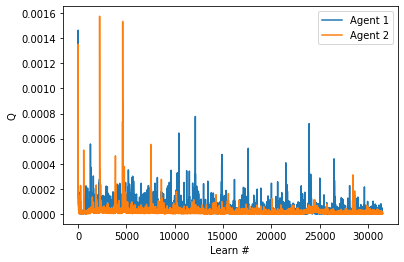

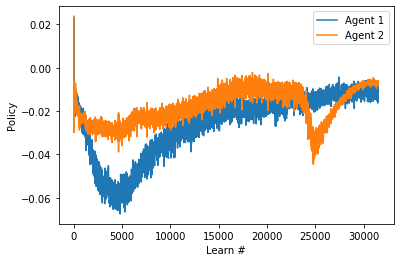

Episode 4500(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 65481           
Episode 4500	Average Score: -0.00                	Timestep: 65481


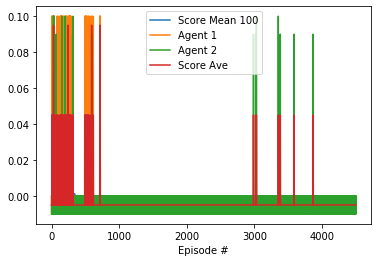

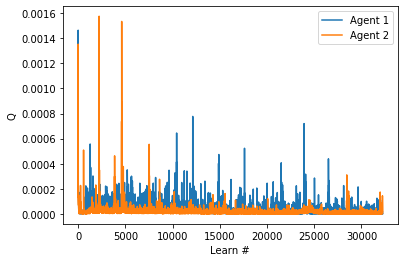

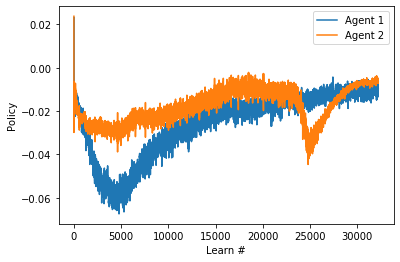

Episode 4600(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 66917           
Episode 4600	Average Score: -0.00                	Timestep: 66917


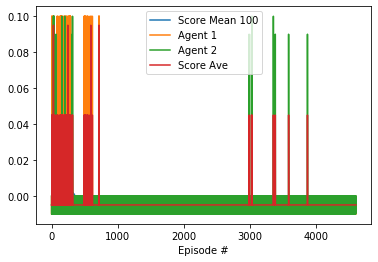

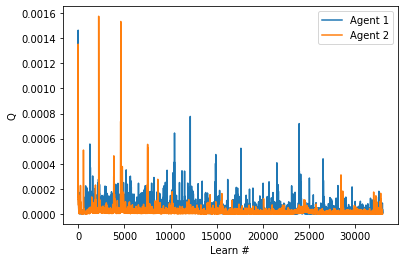

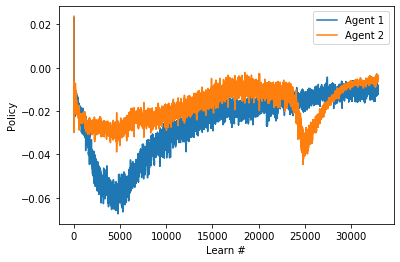

Episode 4700(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 68337           
Episode 4700	Average Score: -0.00                	Timestep: 68337


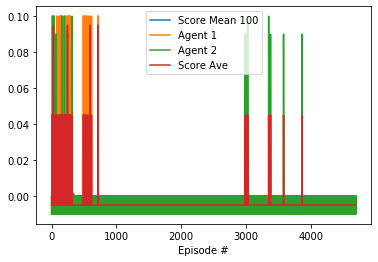

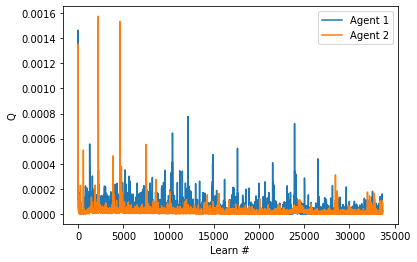

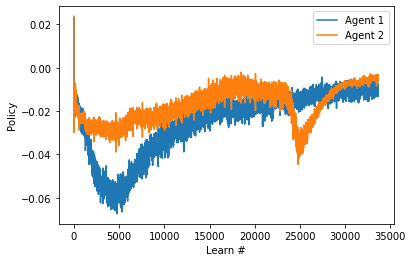

Episode 4800(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 69764           
Episode 4800	Average Score: -0.00                	Timestep: 69764


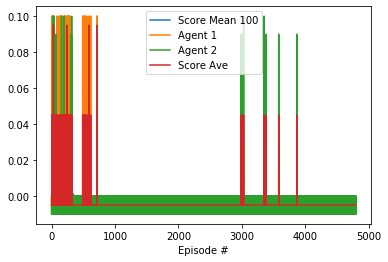

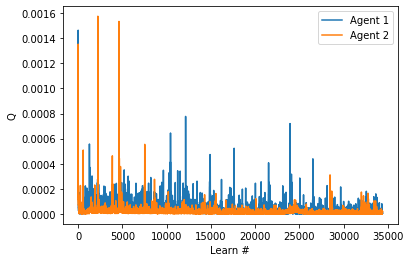

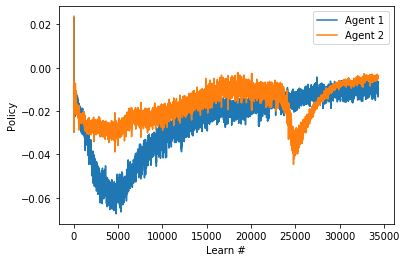

Episode 4900(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00 Batch Size: 71217           
Episode 4900	Average Score: -0.00                	Timestep: 71217


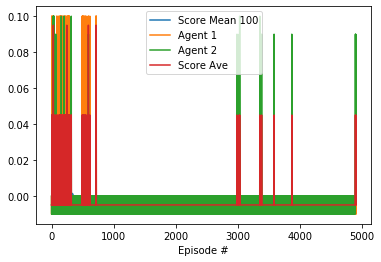

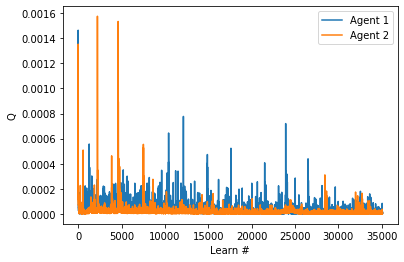

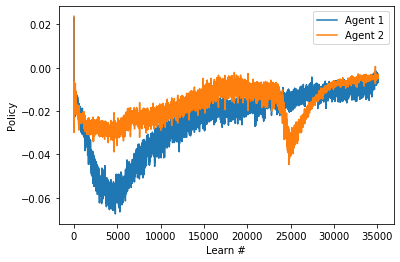

Episode 5000(3sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.00 Batch Size: 72847            
Episode 5000	Average Score: 0.00                	Timestep: 72847


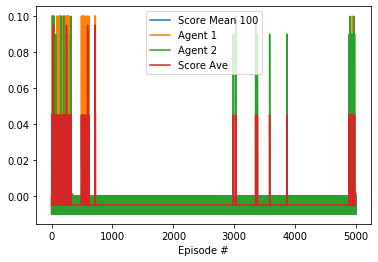

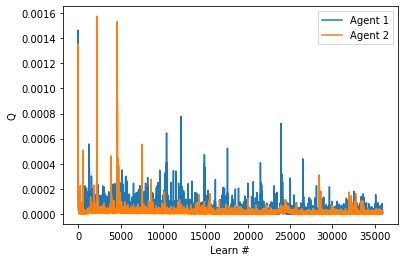

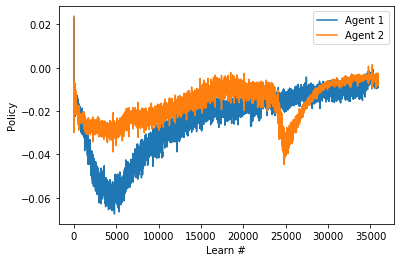

In [76]:
scores_ave, agent = train(n_episodes=5000, random_seed=SEED)

In [78]:
# read model weights
best_agent_0 = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents, agent_index=0)
best_agent_1 = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents, agent_index=1)
# actor_state_dict_0 = torch.load('./actor0_300.pth')
# actor_state_dict_1 = torch.load('./actor1_300.pth')
actor_state_dict_0 = torch.load('./experiment_7/actor0_500.pth')
actor_state_dict_1 = torch.load('./experiment_7/actor1_500.pth')
best_agent_0.actor_local.load_state_dict(actor_state_dict_0)
best_agent_1.actor_local.load_state_dict(actor_state_dict_1)

play([best_agent_0, best_agent_1], t=20)

Score (sum over agents) from episode 0: 0.09
Score (sum over agents) from episode 1: -0.01
Score (sum over agents) from episode 2: -0.01
Score (sum over agents) from episode 3: 0.09
Score (sum over agents) from episode 4: -0.01
Score (sum over agents) from episode 5: 0.09
Score (sum over agents) from episode 6: -0.01
Score (sum over agents) from episode 7: 0.09
Score (sum over agents) from episode 8: -0.01
Score (sum over agents) from episode 9: -0.01
Score (sum over agents) from episode 10: -0.01
Score (sum over agents) from episode 11: -0.01
Score (sum over agents) from episode 12: 0.09
Score (sum over agents) from episode 13: 0.09
Score (sum over agents) from episode 14: 0.09
Score (sum over agents) from episode 15: 0.09
Score (sum over agents) from episode 16: -0.01
Score (sum over agents) from episode 17: 0.09
Score (sum over agents) from episode 18: -0.01
Score (sum over agents) from episode 19: -0.01


In [ ]:
fig, ax = plt.subplots()

plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
plt.xlabel('Episode #')

ax.legend()
plt.show()


In [ ]:
env.close()

In [ ]:
# To test OUNoise hyperparameters
oun = OUNoise(size=1, seed=1, mu=-0.1, theta=0.15, sigma=0.15)
cnt = 10000
result = []
for _ in range(cnt):
    r = oun.sample()
    result.append(r)

fig, ax = plt.subplots()
plt.plot(np.arange(cnt), result, label='OUN noise')

ax.legend()
plt.show()